q1

+---+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+---------+
|   | Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |    Cost |
|   |    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |         |
+---+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+---------+
| 0 |   -0.0 |  -0.0 |     80.0 |      -0.0 |   1000.0 |       0.0 |     -0.0 |        -0.0 |       -0.0 |    nan |   nan | 53200.0 |
| 1 |    0.0 |  16.0 |     64.0 |      -0.0 |   1960.0 |      -0.0 |     -0.0 |      2560.0 |     1600.0 |   40.0 |  40.0 | 78480.0 |
| 2 |    0.0 |  -0.0 |     64.0 |      -0.0 |   1520.0 |      -0.0 |      0.0 |      2560.0 |     3000.0 |   40.0 |  40.0 | 69600.0 |
| 3 |    0.0 |  -0.0 |     64.0 |      -0.0 |    880.0 |      

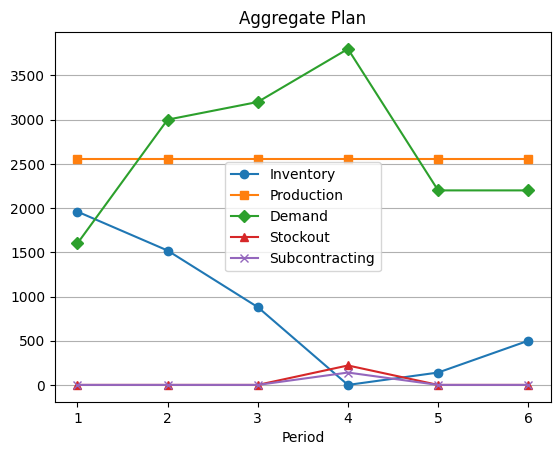

In [10]:
# Install and import packages
!pip install tabulate
!pip install gurobipy
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt
### User defined variables
promote = 0
month = 4
base_price = 40
promotion_price = base_price - 1
consumption = 0.10
forward_buy = 0.20

F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])
def plot_inventory():
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()
  # Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] + [Pr[t]] + [300*H[t].x + 500*L[t].x + 640*W[t].x + 6*O[t].x + 2*I[t].x + 5*S[t].x + 30*C[t].x + 10*P[t].x] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"] + ["Cost"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()


q2

+---+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+---------+
|   | Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |    Cost |
|   |    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |         |
+---+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+---------+
| 0 |   -0.0 |  -0.0 |     80.0 |      -0.0 |   1000.0 |       0.0 |     -0.0 |        -0.0 |       -0.0 |    nan |   nan | 53200.0 |
| 1 |    0.0 |  16.0 |     64.0 |      -0.0 |   2060.0 |      -0.0 |     -0.0 |      2560.0 |     1500.0 |   40.0 |  40.0 | 78680.0 |
| 2 |    0.0 |  -0.0 |     64.0 |      -0.0 |   1620.0 |      -0.0 |      0.0 |      2560.0 |     3000.0 |   40.0 |  40.0 | 69800.0 |
| 3 |    0.0 |  -0.0 |     64.0 |      -0.0 |    980.0 |      

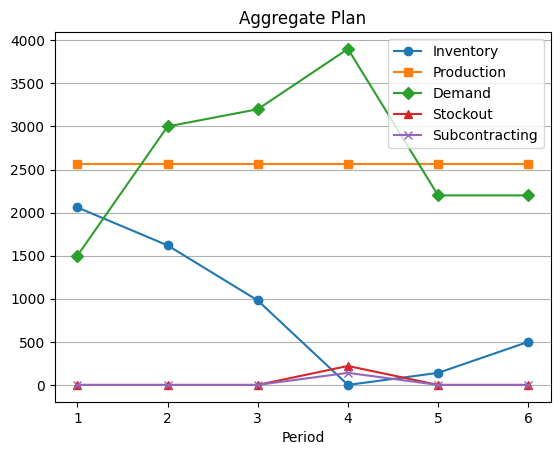

In [11]:
F[1] = 1500  # Adjusted demand for January to 1500 units
F[4] = 3900  # Updated forecast for April to 3900 units
F = np.append(F, 1100)  # Adding demand for July as 1100 units
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months+1)
for t in range(0, n_months + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] + [Pr[t]] + [300*H[t].x + 500*L[t].x + 640*W[t].x + 6*O[t].x + 2*I[t].x + 5*S[t].x + 30*C[t].x + 10*P[t].x] for t in range(0, n_months + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"] + ["Cost"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")

plot_inventory()



q3

In [12]:
Total_Cost_Jan_1600 = 78480.0
Total_Cost_Jan_1500 = 78680.0
Difference = Total_Cost_Jan_1600 - Total_Cost_Jan_1500
print("impact of change of demand in January", Difference)

impact of change of demand in January -200.0


q4

+---+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+---------+
|   | Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand | Price |    Cost |
|   |    (t) |   (H) |      (L) |       (W) |      (O) |       (O) |      (S) |         (C) |        (P) |    (D) |  (Pr) |         |
+---+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+-------+---------+
| 0 |   -0.0 |  -0.0 |     80.0 |      -0.0 |   1000.0 |       0.0 |     -0.0 |        -0.0 |       -0.0 |    nan |   nan | 53200.0 |
| 1 |    0.0 |   4.0 |     76.0 |       0.0 |   1040.0 |       0.0 |      0.0 |      3040.0 |     3000.0 |   40.0 |  40.0 | 83120.0 |
| 2 |    0.0 |   0.0 |     76.0 |       0.0 |    880.0 |       0.0 |      0.0 |      3040.0 |     3200.0 |   40.0 |  40.0 | 80800.0 |
| 3 |    0.0 |   1.0 |     75.0 |       0.0 |      0.0 |      

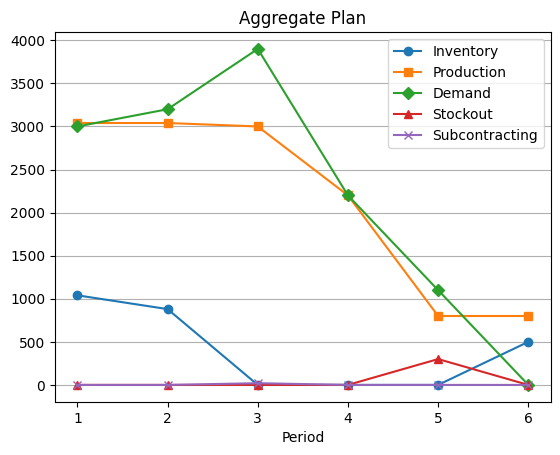

In [27]:

F1 = np.array([0, 3000, 3200, 3900, 2200,2200, 1100])
n_months1 = len(F1)-1

### Variables based on input
n_months = len(F)-1
F = np.append(F, [0, 0])
def plot_inventory(F,n_months):
  t_values = list(range(1, n_months + 1))

  plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
  plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
  plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
  plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
  plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')

  # Adding labels and legend
  plt.xlabel('Period')
  plt.ylabel('')
  plt.legend(loc='best')
  plt.title('Aggregate Plan')
  plt.grid(axis='y')

  # Show the plot
  plt.show()
  # Create a Gurobi model
model = Model("MinimizeCost")

H = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months1+1)}
L = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months1+1)}
W = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months1+1)}
O = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months1+1)}
I = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months1+1)}
S = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months1+1)}
C = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months1+1)}
P = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months1+1)}
D = {(t): model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months1+1)}

# Update the model
model.update()

# Set objective function - Total cost = Production & Transportation cost across network + Fixed cost of low cap line + fixed cost of high cap line
model.setObjective(
    quicksum( 300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I[t] + 5*S[t] + 30*C[t] + 10*P[t] for t in range(1, n_months1+1) ),
    GRB.MINIMIZE)

### Constraints
for t in range(1, n_months1+1):

  # Workforce size for each month is based on hiring and layoffs, W_t = W_{t-1} + H_t - L_t
  model.addConstr(W[0] == 80, name=f"Workforce_Beg")
  model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_size_constraint_{t}")

  # Demand constraints
  if promote == 0:
      model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
  else:
      if t == month:
          model.addConstr(D[t] == F[t] * (1 + consumption) + forward_buy * (F[t+1] + F[t+2]), name=f"D_constraint_{t}")
      else:
          if t <= 2 + promote:
              if t > promote:
                  model.addConstr(D[t] == (1 - forward_buy) * F[t], name=f"D_constraint_{t}")
              else:
                  model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")
          else:
              model.addConstr(D[t] == F[t], name=f"D_constraint_{t}")

  # Inventory balance constraint: I_{t-1} + P_t + C_t = D_t + S_{t-1} + I_t - S_t
  model.addConstr(I[0] == 1000, name=f"Inventory_Beg")
  model.addConstr(I[t-1] + P[t] + C[t] - D[t] - S[t-1] - I[t] + S[t] == 0, name=f"Inventory_constraint_{t}")
  model.addConstr(I[n_months1] >= 500, name=f"Inventory_End")

  # Stockout constraint: No stockout at the end
  model.addConstr(S[n_months1] == 0, name=f"Stockout_End")

  # Production <= Capacity P_t <= 40 W_t + O_t/4
  model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Capacity_constraint_{t}")

  # Overtime constraint O_t <= 10 W_t
  model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_constraint_{t}")


# Suppress optimization output
model.Params.OutputFlag = 0

# Optimize the model
model.optimize()

### Calculate price
Pr = np.zeros(n_months1+1)
for t in range(0, n_months1 + 1):
  if promote == 1 and t == month:
    Pr[t] = promotion_price
  else:
    Pr[t] = base_price
  if t == 0:
    Pr[t] = np.nan

### Total revenue = sumproduct (demand*price)
revenue = sum([D[t].x * Pr[t] for t in range(1, n_months1 + 1)])

# Store result in table format and print
opt_results = [[t] + [H[t].x] + [L[t].x] + [W[t].x] + [O[t].x] + [I[t].x] + [S[t].x] + [C[t].x] + [P[t].x] + [D[t].x] + [Pr[t]] + [Pr[t]] + [300*H[t].x + 500*L[t].x + 640*W[t].x + 6*O[t].x + 2*I[t].x + 5*S[t].x + 30*C[t].x + 10*P[t].x] for t in range(0, n_months1 + 1)]

headers = ["Period\n(t)"] + ["Hired\n(H)"] + ["Laid Off\n(L)"] + ["Workforce\n(W)"] + ["Overtime\n(O)"] + ["Inventory\n(O)"] + ["Stockout\n(S)"] + ["Subcontract\n(C)"] + ["Production\n(P)"] + ["Demand\n(D)"] + ["Price\n(Pr)"] + ["Cost"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty", stralign="right"))

print(f"Minimum Cost : $ {model.objVal:,.2f}")
print(f"Total Revenue: $ {revenue:,.2f}")
print(f"Profit       : $ {(revenue-model.objVal):,.2f}")
plot_inventory(F1,n_months1)


In [32]:
Total_Cost_Jan_june = 422660.00
Total_Cost_feb_july = 371820.00
Difference = Total_Cost_feb_july - Total_Cost_Jan_june
print("cost difference between the plans for the months Feb through June", Difference)

cost difference between the plans for the months Feb through June -50840.0
